In [5]:
using NeuralPDE, Lux, ModelingToolkit, Optimization, OptimizationOptimJL
using ModelingToolkit: Interval
using Plots



## Решение волнового уравнения на плоскости

In [ ]:
@parameters x y
@variables u(..)
Dxx = Differential(x)^2
Dyy = Differential(y)^2

# 2D PDE
eq = Dxx(u(x, y)) + Dyy(u(x, y)) ~ -sin(pi * x) * sin(pi * y)

# Boundary conditions
bcs = [u(0, y) ~ 0.0, u(1, y) ~ 0.0,
    u(x, 0) ~ 0.0, u(x, 1) ~ 0.0]
# Space and time domains
domains = [x ∈ Interval(0.0, 1.0),
    y ∈ Interval(0.0, 1.0)]

In [12]:
# Neural network
dim = 2 # number of dimensions
chain = Chain(Dense(dim, 16, σ), Dense(16, 16, σ), Dense(16, 1))

Chain(
    layer_1 = Dense(2 => 16, σ),        # 48 parameters
    layer_2 = Dense(16 => 16, σ),       # 272 parameters
    layer_3 = Dense(16 => 1),           # 17 parameters
)         # Total: 337 parameters,
          #        plus 0 states.

In [13]:
discretization = PhysicsInformedNN(
    chain, QuadratureTraining(; batch = 200, abstol = 1e-6, reltol = 1e-6))

PhysicsInformedNN{Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, QuadratureTraining{Float64, Integrals.CubatureJLh}, Nothing, NeuralPDE.Phi{StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}, typeof(NeuralPDE.numeric_derivative), Bool, Nothing, Nothing, Nothing, Base.RefValue{Int64}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}}(Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, N

In [14]:
@named pde_system = PDESystem(eq, bcs, domains, [x, y], [u(x, y)])
prob = discretize(pde_system, discretization)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [0.5802323818206787 -1.1752511262893677; -0.5398000478744507 -0.8837103247642517; … ; 1.1979782581329346 0.22969412803649902; -0.7884575128555298 0.4977641701698303], bias = [0.641058623790741, -0.2972918152809143, -0.45211783051490784, 0.061025772243738174, 0.6336343884468079, -0.6276748180389404, -0.05326114222407341, -0.350928395986557, 0.6065211296081543, -0.47438114881515503, 0.40409916639328003, -0.33518949151039124, -0.19400936365127563, -0.18429602682590485, 0.2044048011302948, -0.4180245101451874]), layer_2 = (weight = [-0.09213148802518845 -0.12984499335289001 … -0.1123342365026474 -0.36586058139801025; 0.17831267416477203 -0.15775133669376373 … -0.09619907289743423 0.2714248597621918; … ; -0.11645648628473282 0.24795030057430267 … 0.12348427623510361 0.3276277780532837; 0.38951390981674194 0.11600089818239212 … -0.26839327812194824 0.32003992795944214], bias = [-0.013244658708572388, -0.0682

In [18]:
#Optimizer
opt = OptimizationOptimJL.LBFGS(linesearch = BackTracking())

callback = function (p, l)
    println("Current loss is: $l")
    return false
end

# We can pass the callback function in the solve. Not doing here as the output would be very long.
res = Optimization.solve(prob, opt, maxiters = 1000, callback = callback)
phi = discretization.phi

Current loss is: 0.47193320124892957
Current loss is: 0.26421660319465096
Current loss is: 0.2640544269896464
Current loss is: 0.21712822103238222


InterruptException: InterruptException:

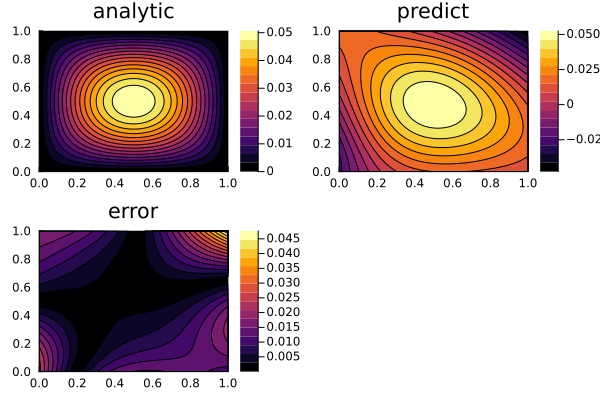

In [17]:
dx = 0.05
xs, ys = [infimum(d.domain):(dx / 10):supremum(d.domain) for d in domains]
analytic_sol_func(x, y) = (sin(pi * x) * sin(pi * y)) / (2pi^2)

u_predict = reshape([first(phi([x, y], res.u)) for x in xs for y in ys],
    (length(xs), length(ys)))
u_real = reshape([analytic_sol_func(x, y) for x in xs for y in ys],
    (length(xs), length(ys)))
diff_u = abs.(u_predict .- u_real)

p1 = plot(xs, ys, u_real, linetype = :contourf, title = "analytic");
p2 = plot(xs, ys, u_predict, linetype = :contourf, title = "predict");
p3 = plot(xs, ys, diff_u, linetype = :contourf, title = "error");
plot(p1, p2, p3)

## Решение уравнения для заряда на плоскости

In [114]:
using NeuralPDE, Lux, ModelingToolkit, Optimization, OptimizationOptimJL, LineSearches,
      OptimizationOptimisers
using ModelingToolkit: Interval, infimum, supremum
using Distributions

In [115]:
@parameters t, x, y, z
@variables E(..)[1:3], B(..)[1:3]

2-element Vector{Symbolics.CallWithMetadata{SymbolicUtils.FnType{Tuple, Vector{Real}}, Base.ImmutableDict{DataType, Any}}}:
 E⋆
 B⋆

In [121]:
Dt = Differential(t)
Dtt = Differential(t)^2
Dx = Differential(x)
Dxx = Differential(x)^2
Dy = Differential(y)
Dxy = Differential(x) * Differential(y)
Dyy = Differential(y)^2
Dz = Differential(z)
Dxz = Differential(x) * Differential(z)
Dzz = Differential(z)^2
Dyz = Differential(y) * Differential(z)

Differential(y) ∘ Differential(z)

In [11]:
using LinearAlgebra, Symbolics

In [123]:
function divergence(f)
    #return sum(Symbolics.sparsejacobian_vals(f, [x; y; z], [1; 2; 3], [1; 2; 3]))
    return Dx(f[1]) + Dy(f[2]) + Dz(f[3])
end
function rotor(f)
    #J = Symbolics.jacobian(f, [x; y; z])
    #ex = J[3, 2] - J[2, 3] Dz(f[2]) - Dy(f[3])
    #ey = J[1, 3] - J[3, 1] Dz(f[2]) - Dy(f[3])
    #ez = J[2, 1] - J[1, 2]
    ex = Dz(f[2]) - Dy(f[3])
    ey = Dx(f[3]) - Dz(f[1])
    ez = Dy(f[1]) - Dx(f[2])
    return [ex; ey; ez]
end

rotor (generic function with 1 method)

In [124]:
@parameters t, x, y, z
@variables E(..)[1:3], B(..)[1:3]

charge = Distributions.MvNormal([0.5; 0.5; 0.5], [1e-3 0.0 0.0; 0.0 1e-3 0.0; 0.0 0.00 1e-3])
rho = (x, y, z) -> Distributions.pdf(charge, [x; y; z])


#75 (generic function with 1 method)

In [126]:
# 3D PDE
eqs = [
    divergence(E(x, y, z)) ~ 4 * pi * rho(x, y, z),
    divergence(B(x, y, z)) ~ 0.0,
    rotor(E(x, y, z)) ~ [0.0; 0.0; 0.0],
    rotor(B(x, y, z)) ~ [0.0; 0.0; 0.0],
]

4-element Vector{Equation}:
 Differential(x)((E(x, y, z))[1]) + Differential(y)((E(x, y, z))[2]) + Differential(z)((E(x, y, z))[3]) ~ 12.566370614359172exp(7.604817318859187 - (1//2)*(abs2(31.622776601683796(-0.5 + x)) + abs2(31.622776601683796(-0.5 + z)) + abs2(31.622776601683796(-0.5 + y))))
 Differential(x)((B(x, y, z))[1]) + Differential(y)((B(x, y, z))[2]) + Differential(z)((B(x, y, z))[3]) ~ 0.0
 Num[Differential(z)((E(x, y, z))[2]) - Differential(y)((E(x, y, z))[3]), Differential(x)((E(x, y, z))[3]) - Differential(z)((E(x, y, z))[1]), Differential(y)((E(x, y, z))[1]) - Differential(x)((E(x, y, z))[2])] ~ [0.0, 0.0, 0.0]
 Num[Differential(z)((B(x, y, z))[2]) - Differential(y)((B(x, y, z))[3]), Differential(x)((B(x, y, z))[3]) - Differential(z)((B(x, y, z))[1]), -Differential(x)((B(x, y, z))[2]) + Differential(y)((B(x, y, z))[1])] ~ [0.0, 0.0, 0.0]

In [95]:




# Boundary conditions
bcs = [E(0, y, z) ~ [0.0; 0.0; 0.0], E(1, y, z) ~ [0.0; 0.0; 0.0], 
    E(x, 0, z) ~ [0.0; 0.0; 0.0], E(x, 1, z) ~ [0.0; 0.0; 0.0],
    E(x, y, 0) ~ [0.0; 0.0; 0.0], E(x, y, 0) ~ [0.0; 0.0; 0.0],
    B(0, y, z) ~ [0.0; 0.0; 0.0], B(1, y, z) ~ [0.0; 0.0; 0.0], 
    B(x, 0, z) ~ [0.0; 0.0; 0.0], B(x, 1, z) ~ [0.0; 0.0; 0.0],
    B(x, y, 0) ~ [0.0; 0.0; 0.0], B(x, y, 0) ~ [0.0; 0.0; 0.0]]
# Space and time domains
domains = [x ∈ Interval(0.0, 1.0),
    y ∈ Interval(0.0, 1.0),
    z ∈ Interval(0.0, 1.0)]

3-element Vector{Symbolics.VarDomainPairing}:
 Symbolics.VarDomainPairing(x, 0.0 .. 1.0)
 Symbolics.VarDomainPairing(y, 0.0 .. 1.0)
 Symbolics.VarDomainPairing(z, 0.0 .. 1.0)

In [96]:
# Neural network
input_ = 3
n = 15
dim = 3 # number of dimensions
chain = [Chain(Dense(input_, n, σ), Dense(n, n, σ), Dense(n, dim)) for _ in 1:2]

2-element Vector{Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}}:
 Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(3 => 15, σ), layer_2 = Dense(15 => 15, σ), layer_3 = Dense(15 => 3)), nothing)  # 348 parameters
 Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(3 => 15, σ), layer_2 = Dense(15 => 15, σ), layer_3 = Dense(15 => 3)), nothing)  # 348 parameter

In [97]:
strategy = StochasticTraining(128)
discretization = PhysicsInformedNN(chain, StochasticTraining(128))

PhysicsInformedNN{Vector{Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}}, StochasticTraining, Nothing, Vector{NeuralPDE.Phi{StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}}, typeof(NeuralPDE.numeric_derivative), Bool, Nothing, Nothing, Nothing, Base.RefValue{Int64}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}}(Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing,

In [110]:
@variables u(..)

1-element Vector{Symbolics.CallWithMetadata{SymbolicUtils.FnType{Tuple, Real}, Base.ImmutableDict{DataType, Any}}}:
 u⋆

In [106]:
@named pde_system = PDESystem(eqs, bcs, domains, [x, y, z], 
    [E(x, y, z), B(x, y, z)])

PDESystem
Equations: Equation[Differential(x)((E(x, y, z))[1]) + Differential(y)((E(x, y, z))[2]) + Differential(z)((E(x, y, z))[3]) ~ 12.566370614359172exp(7.604817318859187 - (1//2)*(abs2(31.622776601683796(-0.5 + x)) + abs2(31.622776601683796(-0.5 + z)) + abs2(31.622776601683796(-0.5 + y)))), Differential(x)((B(x, y, z))[1]) + Differential(y)((B(x, y, z))[2]) + Differential(z)((B(x, y, z))[3]) ~ 0.0, Num[-Differential(z)((E(x, y, z))[2]) + Differential(y)((E(x, y, z))[3]), -Differential(x)((E(x, y, z))[3]) + Differential(z)((E(x, y, z))[1]), -Differential(y)((E(x, y, z))[1]) + Differential(x)((E(x, y, z))[2])] ~ [0.0, 0.0, 0.0], Num[-Differential(z)((B(x, y, z))[2]) + Differential(y)((B(x, y, z))[3]), -Differential(x)((B(x, y, z))[3]) + Differential(z)((B(x, y, z))[1]), Differential(x)((B(x, y, z))[2]) - Differential(y)((B(x, y, z))[1])] ~ [0.0, 0.0, 0.0]]
Boundary Conditions: Equation[E(0, y, z) ~ [0.0, 0.0, 0.0], E(1, y, z) ~ [0.0, 0.0, 0.0], E(x, 0, z) ~ [0.0, 0.0, 0.0], E(x, 1, 

In [107]:
prob = discretize(pde_system, discretization)
sym_prob = symbolic_discretize(pdesystem, discretization)

KeyError: KeyError: key getindex not found

In [ ]:
pde_inner_loss_functions = sym_prob.loss_functions.pde_loss_functions
bcs_inner_loss_functions = sym_prob.loss_functions.bc_loss_functions

In [ ]:
callback = function (p, l)
    println("loss: ", l)
    println("pde_losses: ", map(l_ -> l_(p.u), pde_inner_loss_functions))
    println("bcs_losses: ", map(l_ -> l_(p.u), bcs_inner_loss_functions))
    return false
end

In [23]:
#Optimizer
opt = OptimizationOptimisers.Adam(0.01)

# We can pass the callback function in the solve. Not doing here as the output would be very long.
res = solve(prob, opt; maxiters = 1000, callback)
phi = discretization.phi

Current loss is: 0.6786575502392002
Current loss is: 0.2246784064902313
Current loss is: 0.22453744052590002
Current loss is: 0.17539857237934242
Current loss is: 0.1699412713195661
Current loss is: 0.1625288146458342
Current loss is: 0.15543610182662135
Current loss is: 0.15134556543836025
Current loss is: 0.13393403831788697
Current loss is: 0.11626158789801753
Current loss is: 0.11334875034157552
Current loss is: 0.11001666178434619
Current loss is: 0.10588236247895955
Current loss is: 0.1041037845811871
Current loss is: 0.10262850112022669
Current loss is: 0.0973771191280183
Current loss is: 0.09050347953187007
Current loss is: 0.08581064651623142
Current loss is: 0.07706382050035593
Current loss is: 0.07354481364228821
Current loss is: 0.07182471489364849
Current loss is: 0.07169903534836146
Current loss is: 0.07164603308011445
Current loss is: 0.07109232592046129
Current loss is: 0.07000632241544377
Current loss is: 0.0680557773299788
Current loss is: 0.0662712251739526
Current l

InterruptException: InterruptException:

In [ ]:
dx = 0.05
xs, ys = [infimum(d.domain):(dx / 10):supremum(d.domain) for d in domains]
analytic_sol_func(x, y) = (sin(pi * x) * sin(pi * y)) / (2pi^2)

u_predict = reshape([first(phi([x, y], res.u)) for x in xs for y in ys],
    (length(xs), length(ys)))
u_real = reshape([analytic_sol_func(x, y) for x in xs for y in ys],
    (length(xs), length(ys)))
diff_u = abs.(u_predict .- u_real)

p1 = plot(xs, ys, u_real, linetype = :contourf, title = "analytic");
p2 = plot(xs, ys, u_predict, linetype = :contourf, title = "predict");
p3 = plot(xs, ys, diff_u, linetype = :contourf, title = "error");
plot(p1, p2, p3)

In [190]:
@parameters t, x, y, z
@variables Ex(..), Ey(..), Ez(..), Bx(..), By(..), Bz(..)
E = [Ex, Ey, Ez]
B = [Bx, By, Bz]

Dx = Differential(x)
Dy = Differential(y)
Dz = Differential(z)


charge = Distributions.MvNormal([0.5; 0.5; 0.5], [1e-3 0.0 0.0; 0.0 1e-3 0.0; 0.0 0.00 1e-3])
rho = (x, y, z) -> Distributions.pdf(charge, [x; y; z])

function divergence(f)
    return Dx(f[1](x, y, z)) + Dy(f[2](x, y, z)) + Dz(f[3](x, y, z))
end
function rotor(f)
    ex = Dz(f[2](x, y, z)) - Dy(f[3](x, y, z))
    ey = Dx(f[3](x, y, z)) - Dz(f[1](x, y, z))
    ez = Dy(f[1](x, y, z)) - Dx(f[2](x, y, z))
    return [ex; ey; ez]
end


rotor (generic function with 1 method)

In [191]:
rotor(E)

3-element Vector{Num}:
  Differential(z)(Ey(x, y, z)) - Differential(y)(Ez(x, y, z))
  Differential(x)(Ez(x, y, z)) - Differential(z)(Ex(x, y, z))
 -Differential(x)(Ey(x, y, z)) + Differential(y)(Ex(x, y, z))

In [192]:
function retrv(f, x, y, z)
    return [f[1](x,y,z); f[2](x,y,z); f[3](x,y,z)]
end

retrv (generic function with 2 methods)

In [ ]:

eqs = [
    divergence(E) ~ 4 * pi * rho(x, y, z),
    divergence(B) ~ 0.0,
    rotor(E) ~ [0.0; 0.0; 0.0],
    rotor(B) ~ [0.0; 0.0; 0.0],
]


In [199]:

eqs = [
    divergence(E) ~ 4 * pi * rho(x, y, z),
    divergence(B) ~ 0.0,
    Dz(E[2](x, y, z)) - Dy(E[3](x, y, z)) ~ 0.0,
    Dx(E[3](x, y, z)) - Dz(E[1](x, y, z)) ~ 0.0,
    Dy(E[1](x, y, z)) - Dx(E[2](x, y, z)) ~ 0.0,
    Dz(B[2](x, y, z)) - Dy(B[3](x, y, z)) ~ 0.0,
    Dx(B[3](x, y, z)) - Dz(B[1](x, y, z)) ~ 0.0,
    Dy(B[1](x, y, z)) - Dx(B[2](x, y, z)) ~ 0.0
]

8-element Vector{Equation}:
 Differential(x)(Ex(x, y, z)) + Differential(z)(Ez(x, y, z)) + Differential(y)(Ey(x, y, z)) ~ 12.566370614359172exp(7.604817318859187 - (1//2)*(abs2(31.622776601683796(-0.5 + x)) + abs2(31.622776601683796(-0.5 + z)) + abs2(31.622776601683796(-0.5 + y))))
 Differential(x)(Bx(x, y, z)) + Differential(y)(By(x, y, z)) + Differential(z)(Bz(x, y, z)) ~ 0.0
 Differential(z)(Ey(x, y, z)) - Differential(y)(Ez(x, y, z)) ~ 0.0
 Differential(x)(Ez(x, y, z)) - Differential(z)(Ex(x, y, z)) ~ 0.0
 -Differential(x)(Ey(x, y, z)) + Differential(y)(Ex(x, y, z)) ~ 0.0
 -Differential(y)(Bz(x, y, z)) + Differential(z)(By(x, y, z)) ~ 0.0
 Differential(x)(Bz(x, y, z)) - Differential(z)(Bx(x, y, z)) ~ 0.0
 Differential(y)(Bx(x, y, z)) - Differential(x)(By(x, y, z)) ~ 0.0

In [208]:
bcs = [Ex(0, y, z) ~ 0.0, Ex( 1, y, z) ~ 0.0, 
Ey(0, y, z) ~ 0.0, Ey( 1, y, z) ~ 0.0, 
Ez(0, y, z) ~ 0.0, Ez( 1, y, z) ~ 0.0, 

Ex(x, 0, z) ~ 0.0, Ex( x, 1, z) ~ 0.0, 
Ey(x, 0, z) ~ 0.0, Ey( x, 1, z) ~ 0.0, 
Ez(x, 0, z) ~ 0.0, Ez( x, 1, z) ~ 0.0, 

Ex(x, y, 0) ~ 0.0, Ex( x, y, 1) ~ 0.0, 
Ey(x, y, 0) ~ 0.0, Ey( x, y, 1) ~ 0.0, 
Ez(x, y, 0) ~ 0.0, Ez( x, y, 1) ~ 0.0, 


Bx(0, y, z) ~ 0.0, Bx( 1, y, z) ~ 0.0, 
By(0, y, z) ~ 0.0, By( 1, y, z) ~ 0.0, 
Bz(0, y, z) ~ 0.0, Bz( 1, y, z) ~ 0.0, 

Bx(x, 0, z) ~ 0.0, Bx( x, 1, z) ~ 0.0, 
By(x, 0, z) ~ 0.0, By( x, 1, z) ~ 0.0, 
Bz(x, 0, z) ~ 0.0, Bz( x, 1, z) ~ 0.0, 

Bx(x, y, 0) ~ 0.0, Bx( x, y, 1) ~ 0.0, 
By(x, y, 0) ~ 0.0, By( x, y, 1) ~ 0.0, 
Bz(x, y, 0) ~ 0.0, Bz( x, y, 1) ~ 0.0]

36-element Vector{Equation}:
 Ex(0, y, z) ~ 0.0
 Ex(1, y, z) ~ 0.0
 Ey(0, y, z) ~ 0.0
 Ey(1, y, z) ~ 0.0
 Ez(0, y, z) ~ 0.0
 Ez(1, y, z) ~ 0.0
 Ex(x, 0, z) ~ 0.0
 Ex(x, 1, z) ~ 0.0
 Ey(x, 0, z) ~ 0.0
 Ey(x, 1, z) ~ 0.0
 ⋮
 By(x, 1, z) ~ 0.0
 Bz(x, 0, z) ~ 0.0
 Bz(x, 1, z) ~ 0.0
 Bx(x, y, 0) ~ 0.0
 Bx(x, y, 1) ~ 0.0
 By(x, y, 0) ~ 0.0
 By(x, y, 1) ~ 0.0
 Bz(x, y, 0) ~ 0.0
 Bz(x, y, 1) ~ 0.0

In [209]:
# Space and time domains
domains = [x ∈ Interval(0.0, 1.0),
    y ∈ Interval(0.0, 1.0),
    z ∈ Interval(0.0, 1.0)]

# Neural network
input_ = length(domains)
n = 15
chain = [Chain(Dense(input_, n, σ), Dense(n, n, σ), Dense(n, 1)) for _ in 1:6]

strategy = StochasticTraining(128)
discretization = PhysicsInformedNN(chain, strategy)

PhysicsInformedNN{Vector{Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}}, StochasticTraining, Nothing, Vector{NeuralPDE.Phi{StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}}, typeof(NeuralPDE.numeric_derivative), Bool, Nothing, Nothing, Nothing, Base.RefValue{Int64}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}}(Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing,

In [210]:
@named pdesystem = PDESystem(eqs, bcs, domains, [x, y, z], [Ex(x, y, z), Ey(x, y, z),Ez(x, y, z), Bx(x, y, z), By(x, y, z), Bz(x, y, z)])

PDESystem
Equations: Equation[Differential(x)(Ex(x, y, z)) + Differential(z)(Ez(x, y, z)) + Differential(y)(Ey(x, y, z)) ~ 12.566370614359172exp(7.604817318859187 - (1//2)*(abs2(31.622776601683796(-0.5 + x)) + abs2(31.622776601683796(-0.5 + z)) + abs2(31.622776601683796(-0.5 + y)))), Differential(x)(Bx(x, y, z)) + Differential(y)(By(x, y, z)) + Differential(z)(Bz(x, y, z)) ~ 0.0, Differential(z)(Ey(x, y, z)) - Differential(y)(Ez(x, y, z)) ~ 0.0, Differential(x)(Ez(x, y, z)) - Differential(z)(Ex(x, y, z)) ~ 0.0, -Differential(x)(Ey(x, y, z)) + Differential(y)(Ex(x, y, z)) ~ 0.0, -Differential(y)(Bz(x, y, z)) + Differential(z)(By(x, y, z)) ~ 0.0, Differential(x)(Bz(x, y, z)) - Differential(z)(Bx(x, y, z)) ~ 0.0, Differential(y)(Bx(x, y, z)) - Differential(x)(By(x, y, z)) ~ 0.0]
Boundary Conditions: Equation[Ex(0, y, z) ~ 0.0, Ex(1, y, z) ~ 0.0, Ey(0, y, z) ~ 0.0, Ey(1, y, z) ~ 0.0, Ez(0, y, z) ~ 0.0, Ez(1, y, z) ~ 0.0, Ex(x, 0, z) ~ 0.0, Ex(x, 1, z) ~ 0.0, Ey(x, 0, z) ~ 0.0, Ey(x, 1, z) 

In [211]:
prob = discretize(pdesystem, discretization)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(depvar = (Ex = (layer_1 = (weight = [0.8435359001159668 0.1591130495071411 -0.36228036880493164; 0.27354395389556885 0.8779127597808838 -0.532199501991272; … ; -0.9238806962966919 0.10532927513122559 -0.48439180850982666; -0.9926364421844482 -0.8170608282089233 -0.2339770793914795], bias = [-0.26552683115005493, 0.5249033570289612, 0.34746313095092773, -0.4777546525001526, -0.05958183482289314, -0.2488102912902832, 0.49129346013069153, 0.24719847738742828, -0.07862351834774017, 0.16098074615001678, 0.12689490616321564, 0.03959167003631592, -0.3181729316711426, 0.3429117202758789, -0.32063934206962585]), layer_2 = (weight = [-0.378581702709198 -0.3693653345108032 … -0.062088340520858765 -0.005634599830955267; 0.025171959772706032 0.3535800278186798 … 0.04847000166773796 0.14320698380470276; … ; 0.353667289018631 -0.0776003748178482 … 0.41749563813209534 -0.2647303342819214; 0.2408955991268158 0.4459178149700165 … 0.1517356

In [212]:
sym_prob = symbolic_discretize(pdesystem, discretization)

NeuralPDE.PINNRepresentation(Equation[Differential(x)(Ex(x, y, z)) + Differential(z)(Ez(x, y, z)) + Differential(y)(Ey(x, y, z)) ~ 12.566370614359172exp(7.604817318859187 - (1//2)*(abs2(31.622776601683796(-0.5 + x)) + abs2(31.622776601683796(-0.5 + z)) + abs2(31.622776601683796(-0.5 + y)))), Differential(x)(Bx(x, y, z)) + Differential(y)(By(x, y, z)) + Differential(z)(Bz(x, y, z)) ~ 0.0, Differential(z)(Ey(x, y, z)) - Differential(y)(Ez(x, y, z)) ~ 0.0, Differential(x)(Ez(x, y, z)) - Differential(z)(Ex(x, y, z)) ~ 0.0, -Differential(x)(Ey(x, y, z)) + Differential(y)(Ex(x, y, z)) ~ 0.0, -Differential(y)(Bz(x, y, z)) + Differential(z)(By(x, y, z)) ~ 0.0, Differential(x)(Bz(x, y, z)) - Differential(z)(Bx(x, y, z)) ~ 0.0, Differential(y)(Bx(x, y, z)) - Differential(x)(By(x, y, z)) ~ 0.0], Equation[Ex(0, y, z) ~ 0.0, Ex(1, y, z) ~ 0.0, Ey(0, y, z) ~ 0.0, Ey(1, y, z) ~ 0.0, Ez(0, y, z) ~ 0.0, Ez(1, y, z) ~ 0.0, Ex(x, 0, z) ~ 0.0, Ex(x, 1, z) ~ 0.0, Ey(x, 0, z) ~ 0.0, Ey(x, 1, z) ~ 0.0  …  By

In [213]:
pde_inner_loss_functions = sym_prob.loss_functions.pde_loss_functions
bcs_inner_loss_functions = sym_prob.loss_functions.bc_loss_functions

callback = function (p, l)
    println("loss: ", l)
    println("pde_losses: ", map(l_ -> l_(p.u), pde_inner_loss_functions))
    println("bcs_losses: ", map(l_ -> l_(p.u), bcs_inner_loss_functions))
    return false
end

res = solve(prob, OptimizationOptimisers.Adam(0.01); maxiters = 1000, callback)
prob = remake(prob, u0 = res.u)
res = solve(prob, LBFGS(linesearch = BackTracking()); maxiters = 200, callback)
phi = discretization.phi

loss: 350.42248448004244
pde_losses: [1.977807186056281e6, 0.005030303776989493, 0.0032319886284693585, 0.0006161806404234804, 0.00033812082211786534, 0.0014142435496261713, 0.003377333091486825, 0.00015074500957843826]
bcs_losses: [0.21836691836192795, 0.186735010244131, 0.19721339733635881, 0.1873183796134056, 0.1812237873976107, 0.1977741442499481, 0.19854922885405832, 0.2045897635110735, 0.1868117860046916, 0.19947956664752498, 0.19943012344911973, 0.18089023303959945, 0.19818018028757994, 0.20491737143706945, 0.21004372121367088, 0.17991692569458007, 0.2004456638556082, 0.1777453157328025, 0.04760104676933899, 0.024070433157915665, 0.0012171041689714016, 0.0004854206318449156, 0.09614538638612362, 0.08506263050448291, 0.036221788388635295, 0.033666006028818946, 0.0015888901966836203, 0.00037615444769123984, 0.09126523773051416, 0.08948162500975135, 0.04336798010909516, 0.028626910017534875, 7.0714092983199e-5, 0.0021866485901475877, 0.0954505484569731, 0.08464653626350517]
loss: 3

Excessive output truncated after 524298 bytes.

1.278608081130411e6
pde_losses: [205.06694006282277, 5.953538866151839e-6, 0.047346862063328124, 0.058325038353913304, 0.028350644205751716, 2.363151694898585e-6, 4.3998187777044295e-6, 1.7252348612641885e-6]
bcs_losses: [3.2846347237583897, 7.06692614048064, 2.0092977130040204, 1.8963838526168786, 2.34176365185192, 2.2335759307565675, 2.284422609379615, 1.793663264773097, 6.068758943941622, 5.070074954573465, 2.466752523984539, 2.0040204773146666, 2.103600075141281, 1.7573001953032448, 1.7243626231096105, 2.0304537915972913, 5.5160714951352015, 6.8719429288596245, 4.40024431556054e-7, 4.3471151953871937e-7, 3.9061016500651706e-7, 5.598194730719556e-7, 1.707170812134199e-7, 4.163978301075838e-7, 3.020672475934569e-7, 3.7218481493893934e-7, 5.316187345569627e-7, 6.653084838577128e-7, 2.86605723256206e-7, 6.772960958778474e-7, 5.271291573450757e-7, 4.160339646133419e-7, 1.8959503848993056e-7, 4.227009981539571e-7, 2.99144255886215e-7, 4.2551372439382994e-7]
loss: 273.7118046042088
pde_lo

6-element Vector{NeuralPDE.Phi{StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}}:
 NeuralPDE.Phi{StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}(StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_

In [216]:
phi = discretization.phi

6-element Vector{NeuralPDE.Phi{StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}}:
 NeuralPDE.Phi{StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}(StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_

In [225]:
minimizers_ = [res.u.depvar[sym_prob.depvars[i]] for i in 1:6]

6-element Vector{ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(layer_1 = ViewAxis(1:60, Axis(weight = ViewAxis(1:45, ShapedAxis((15, 3))), bias = 46:60)), layer_2 = ViewAxis(61:300, Axis(weight = ViewAxis(1:225, ShapedAxis((15, 15))), bias = 226:240)), layer_3 = ViewAxis(301:316, Axis(weight = ViewAxis(1:15, ShapedAxis((1, 15))), bias = 16:16)))}}}}:
 ComponentVector{Float64}(layer_1 = (weight = [2.742636522649909 0.3383593243026939 -1.020616167842457; 2.6620285577567566 0.7011250469990394 -2.2147883223983964; … ; -3.4413338142323546 1.8303464567085717 -1.3010652679591879; -3.5892618000560295 0.10155211800899018 1.0998370711286782], bias = [-1.1631663987357714, -0.724980783440666, -0.8288226894383917, 0.7310995547194529, 0.7764750854320283, -0.9409279892181931, 1.259427411223626, 1.1845994055680458, -0.8213741972555794, -0.14435638963905506, -0.5831528280844211, 1.0325403266978923, -1.5447145782102796, 1.4374934476817711, 1.1291280126638952]), la

In [236]:
phi[4]

NeuralPDE.Phi{StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}(StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}(Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static

In [242]:
phi[4]([0,0,0], minimizers_[6])

1-element Vector{Float64}:
 2.1212583015836617e-5

In [ ]:
using Plots

phi = discretization.phi
xs, ys, zs = [infimum(d.domain):0.01:supremum(d.domain) for d in domains]

minimizers_ = [res.u.depvar[sym_prob.depvars[i]] for i in 1:1]

function analytic_sol_func(t, x)
    [exp(-t) * sinpi(x), exp(-t) * cospi(x), (1 + pi^2) * exp(-t)]
end

u_real = [[analytic_sol_func(xs, ys)[1] for xs in xs for ys in ys] for i in 1:1]
u_predict = [[phi[i]([x, y, 0], minimizers_[i])[1] for xs in xs for ys in ys] for i in 1:1]

diff_u = [abs.(u_real[i] .- u_predict[i]) for i in 1:1]
ps = []
for i in 1:1
    p1 = plot(xs, ys, u_real[i], linetype = :contourf, title = "u$i, analytic")
    p2 = plot(xs, ys, u_predict[i], linetype = :contourf, title = "predict")
    p3 = plot(xs, ys, diff_u[i], linetype = :contourf, title = "error")
    push!(ps, plot(p1, p2, p3))
end